In [1]:
import pandas as pd
import numpy as np
import psycopg2
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline
sns.set_style('darkgrid')

## Determine Financial Rotation Age

In [3]:
conn = psycopg2.connect("dbname='carbon' user='postgres' host='localhost'") # password in pgpass file
SQL = '''
SELECT fvs_econsummary.*, fvs_cases.mgmtid, CAST (fvs_cases.standid AS INT) AS siteindex, 
    fvs_summary.age, fvs_summary.tcuft, fvs_summary.mcuft, fvs_summary.bdft, fvs_carbon.total_stand_carbon AS carbon
FROM fvs_econsummary, fvs_cases, fvs_summary, fvs_carbon
WHERE fvs_econsummary.caseid = fvs_cases.caseid AND fvs_summary.caseid = fvs_econsummary.caseid 
    AND fvs_summary.year = fvs_econsummary.year AND fvs_carbon.caseid = fvs_summary.caseid 
    AND fvs_carbon.year = fvs_summary.year;
'''
short = pd.read_sql(SQL, conn)

# close the database connection
conn.close()

In [4]:
short.head()

,caseid,standid,year,period,pretend_harvest,undiscounted_cost,undiscounted_revenue,discounted_cost,discounted_revenue,pnv,...,mrch_boardfoot_volume,discount_rate,given_sev,mgmtid,siteindex,age,tcuft,mcuft,bdft,carbon
0,8a480dea-3f16-400b-98ff-001180c43e52,105,2027,12,NO,957.55,0.0,844.893,0.00,-844.893,...,0,5.0,None,C_SC,105,9,132.0,0.0,0.0,11.2112
1,8a480dea-3f16-400b-98ff-001180c43e52,105,2066,51,YES,12212.70,78024.5,2143.990,9534.85,7390.860,...,36630,5.0,None,C_SC,105,48,9174.0,8749.0,37171.0,115.4940
2,8a480dea-3f16-400b-98ff-001180c43e52,105,2072,57,YES,13175.30,111292.0,1972.160,11281.70,9309.570,...,39418,5.0,None,C_SC,105,54,10160.0,9733.0,39983.0,128.1480
3,8a480dea-3f16-400b-98ff-001180c43e52,105,2078,63,YES,14465.00,159812.0,1847.750,13376.70,11529.000,...,43416,5.0,None,C_SC,105,60,11224.0,10767.0,43978.0,140.1300
4,4f92fc64-11c9-42ae-8a3e-b9a499156d12,110,2027,12,NO,957.55,0.0,844.893,0.00,-844.893,...,0,5.0,None,C_SC,110,9,144.0,0.0,0.0,11.3643


In [5]:
short['siteclass'] = pd.cut(short.siteindex, bins=[0,75,95,115,135,161], 
                           labels=[5, 4, 3, 2, 1], right=False).astype('int')
short['mai_mcuft'] = short.mcuft / short.age
short['mai_tcuft'] = short.tcuft/ short.age
short['mai_bdft'] = short.bdft/ short.age
short = short.sort_values(by=['caseid', 'year'])

In [6]:
cols = ['caseid', 'year', 'pnv']
pnv_smooth = short[cols].groupby('caseid').rolling(window=5, on='year').mean().reset_index()[['caseid', 'year', 'pnv']]
short = short.merge(pnv_smooth, how='left', on=['caseid', 'year'], suffixes=('','_smooth'))

In [7]:
short.columns

Index(['caseid', 'standid', 'year', 'period', 'pretend_harvest',
       'undiscounted_cost', 'undiscounted_revenue', 'discounted_cost',
       'discounted_revenue', 'pnv', 'irr', 'bc_ratio', 'rrr', 'sev',
       'value_of_forest', 'value_of_trees', 'mrch_cubic_volume',
       'mrch_boardfoot_volume', 'discount_rate', 'given_sev', 'mgmtid',
       'siteindex', 'age', 'tcuft', 'mcuft', 'bdft', 'carbon', 'siteclass',
       'mai_mcuft', 'mai_tcuft', 'mai_bdft', 'pnv_smooth'],
      dtype='object')

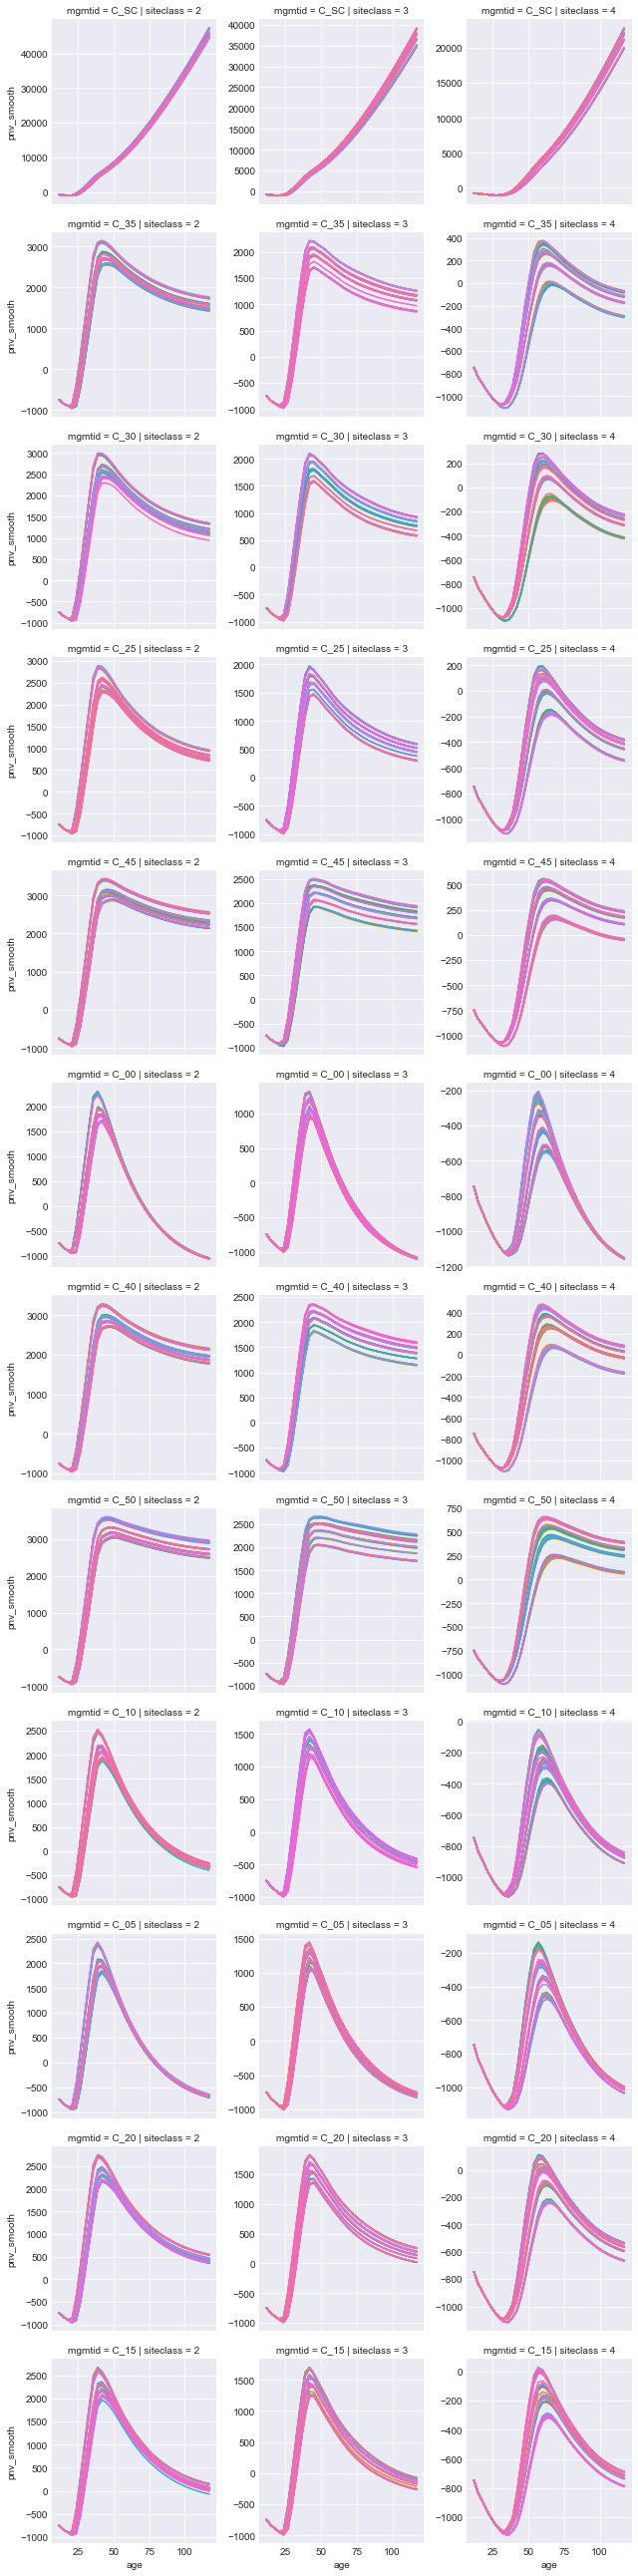

In [8]:
g = sns.FacetGrid(data=short, col='siteclass', row='mgmtid', hue='caseid', sharey=False)
g = g.map(plt.plot, 'age', 'pnv_smooth');

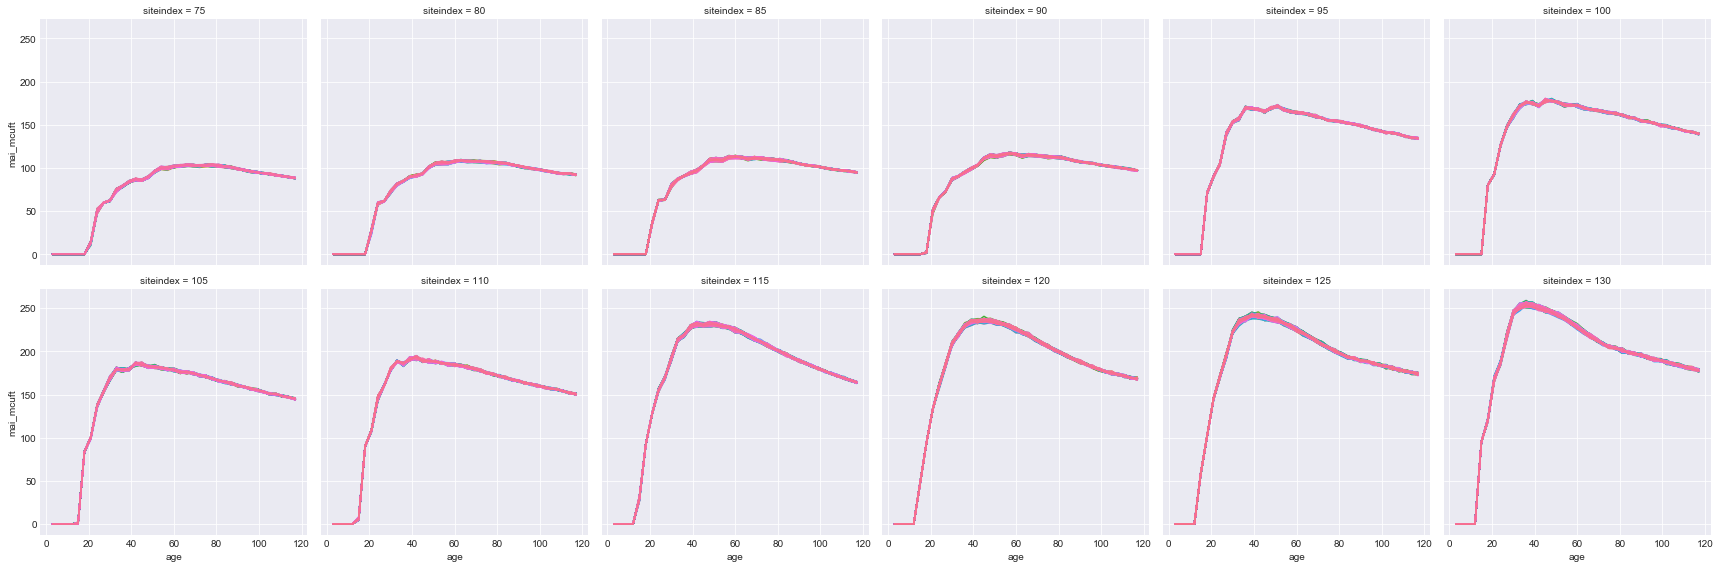

In [9]:
g = sns.FacetGrid(data=short, col='siteindex', hue='caseid', 
                  col_wrap=6, size=4)
g = g.map(plt.plot, 'age', 'mai_mcuft');

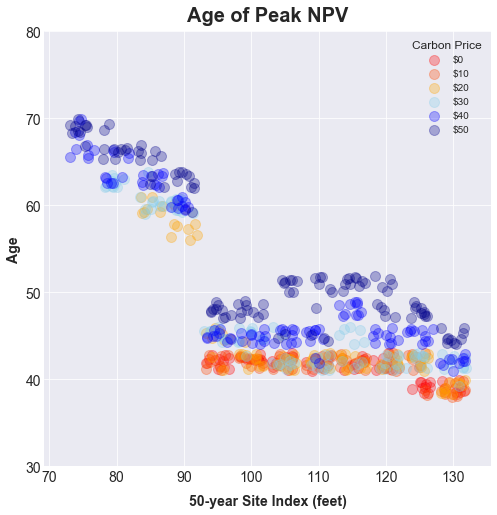

In [8]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
prices = ['00', '10', '20', '30', '40', '50']
colors = ['red', 'orangered', 'orange', 'skyblue', 'blue', 'darkblue', 'black']

for i in range(len(prices)):
    # we only want to know peak NPV if it is positive, lower site classes have negative NPV
    positive = short.loc[short.mgmtid == 'C_'+prices[i]].loc[short.pnv_smooth > 0]
    maxes = positive[['age', 'siteindex']].loc[positive.groupby(['caseid', 'siteindex'])['pnv_smooth'].idxmax()]

    g = sns.regplot(x="siteindex", y="age", data=maxes, fit_reg=False, 
               x_jitter=2, y_jitter=1, scatter_kws={'s': 100, 'color':colors[i], 'alpha':0.3}, ax=ax, label='${:,.0f}'.format(int(prices[i])))

plt.ylim(30,80)
#plt.xlim(70,135)
plt.title('Age of Peak NPV', fontsize=20, weight='bold', pad=10)
plt.xlabel("50-year Site Index (feet)", fontsize=14, weight='bold', labelpad=10)
plt.ylabel("Age", fontsize=14, weight='bold')
plt.legend().set_title('Carbon Price',prop={'size':12})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('PeakNPV_withCarbon.png');

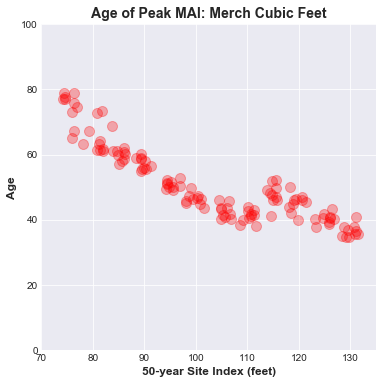

In [9]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

# we only want to know peak NPV if it is positive, lower site classes have negative NPV
positive = short.loc[short.mgmtid == 'C_00']
maxes = positive[['age', 'siteindex']].loc[positive.groupby(['caseid', 'siteindex'])['mai_mcuft'].idxmax()]

g = sns.regplot(x="siteindex", y="age", data=maxes, fit_reg=False, 
               x_jitter=2, y_jitter=2, scatter_kws={'color':'red', 'alpha':0.3, 's':100}, ax=ax)

plt.ylim(0,100)
plt.xlim(70,135)
plt.title('Age of Peak MAI: Merch Cubic Feet', fontsize=14, weight='bold')
plt.xlabel("50-year Site Index (feet)", fontsize=12, weight='bold')
plt.ylabel("Age", fontsize=12, weight='bold');

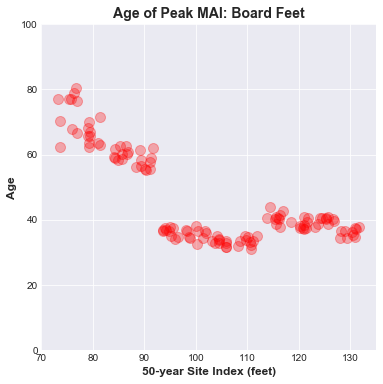

In [10]:
fig, ax = plt.subplots(1,1, figsize=(6,6))

# we only want to know peak NPV if it is positive, lower site classes have negative NPV
positive = short.loc[short.mgmtid == 'C_00']
maxes = positive[['age', 'siteindex']].loc[positive.groupby(['caseid', 'siteindex'])['mai_bdft'].idxmax()]

g = sns.regplot(x="siteindex", y="age", data=maxes, fit_reg=False, 
               x_jitter=2, y_jitter=2, scatter_kws={'color':'red', 'alpha':0.3, 's':100}, ax=ax)

plt.ylim(0,100)
plt.xlim(70,135)
plt.title('Age of Peak MAI: Board Feet', fontsize=14, weight='bold')
plt.xlabel("50-year Site Index (feet)", fontsize=12, weight='bold')
plt.ylabel("Age", fontsize=12, weight='bold');

## Added Value to Long Rotations

In [11]:
cmai_summary = short[['mgmtid', 'year', 'siteindex','pnv_smooth', 'mai_bdft', 'age', 'sev', 'carbon']].loc[short.groupby(['mgmtid', 'caseid', 'siteindex'])['mai_mcuft'].idxmax()][['mgmtid', 'siteindex', 'pnv_smooth', 'mai_bdft', 'age', 'sev', 'carbon']]

In [12]:
cmai_pnv_pivot = pd.pivot_table(cmai_summary, values='pnv_smooth', index='siteindex', columns='mgmtid', aggfunc='mean')
cmai_pnv_pivot.style.format("{:,.0f}")

mgmtid,C_00,C_05,C_10,C_15,C_20,C_25,C_30,C_35,C_40,C_45,C_50,C_SC
siteindex,,,,,,,,,,,,
75,-702,-560,-493,-397,-290,-219,-136,-50,31,137,230,"5,762"
80,-497,-379,-295,-205,-110,-19,72,161,267,345,440,"4,655"
85,-347,-261,-187,-101,-2,85,171,263,343,441,527,"3,988"
90,-240,-158,-78,10,88,169,244,333,435,520,612,"3,742"
95,566,716,863,960,"1,175","1,320","1,472","1,614","1,805","1,954","2,089","5,359"
100,935,"1,092","1,195","1,338","1,491","1,645","1,787","1,942","2,076","2,210","2,359","4,932"
105,"1,165","1,285","1,410","1,536","1,677","1,808","1,937","2,060","2,191","2,340","2,448","4,709"
110,"1,295","1,398","1,534","1,657","1,807","1,903","2,026","2,163","2,274","2,423","2,567","4,407"
115,"1,382","1,617","1,764","1,875","2,076","2,226","2,384","2,544","2,692","2,866","3,005","5,971"


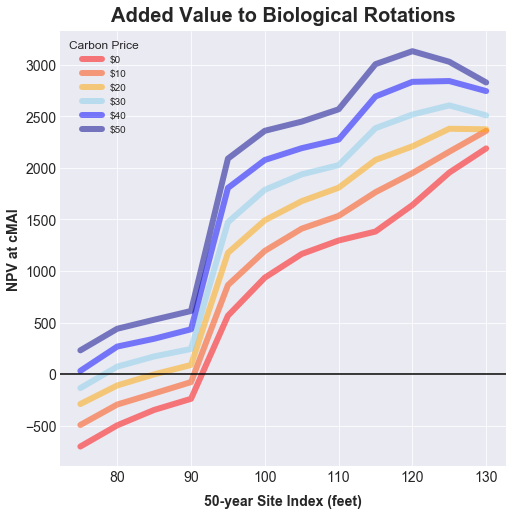

In [13]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
prices = ['00', '10', '20', '30', '40', '50']
colors = ['red', 'orangered', 'orange', 'skyblue', 'blue', 'darkblue', 'black']

for i in range(len(prices)):
    ax.plot(cmai_pnv_pivot['C_'+prices[i]], color=colors[i], label='${:.0f}'.format(int(prices[i])), lw=6, alpha=0.5)
plt.legend(title='Carbon Price')
plt.title('Added Value to Biological Rotations', fontsize=20, weight='bold', pad=10)
plt.xlabel("50-year Site Index (feet)", fontsize=14, weight='bold', labelpad=10)
plt.ylabel("NPV at cMAI", fontsize=14, weight='bold')
plt.legend().set_title('Carbon Price',prop={'size':12})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.axhline(y=0, c='k')
plt.savefig('cMAI_moreNPV_withCarbon.png');

In [14]:
pd.pivot_table(cmai_summary, values='age', index='siteindex', columns='mgmtid', aggfunc='mean').style.format("{:,.0f}")

mgmtid,C_00,C_05,C_10,C_15,C_20,C_25,C_30,C_35,C_40,C_45,C_50,C_SC
siteindex,,,,,,,,,,,,
75,75,72,73,73,71,72,73,74,76,74,73,72
80,65,64,64,64,64,65,64,65,64,64,63,64
85,60,58,58,60,60,59,59,59,59,60,60,60
90,57,57,57,57,57,57,57,58,58,58,58,57
95,51,51,51,50,51,51,51,51,51,51,51,50
100,46,46,46,46,46,46,46,45,45,47,47,46
105,43,43,43,43,43,43,43,43,43,44,43,44
110,41,40,41,41,42,41,41,41,41,41,42,41
115,48,47,47,48,47,47,46,48,48,47,47,45


In [15]:
pd.pivot_table(cmai_summary, values='sev', index='siteindex', columns='mgmtid', aggfunc='mean').style.format("{:,.0f}")

mgmtid,C_00,C_05,C_10,C_15,C_20,C_25,C_30,C_35,C_40,C_45,C_50,C_SC
siteindex,,,,,,,,,,,,
75,-751,-599,-523,-412,-289,-204,-113,-18,65,192,296,"7,489"
80,-546,-408,-296,-201,-94,6,117,221,342,440,558,"6,324"
85,-381,-247,-145,-74,41,162,269,371,478,577,681,"5,648"
90,-272,-159,-59,47,151,261,357,448,572,663,780,"5,419"
95,395,589,781,"1,066","1,182","1,371","1,566","1,752","1,991","2,182","2,361","7,759"
100,778,990,"1,135","1,332","1,541","1,748","1,945","2,174","2,353","2,524","2,722","7,181"
105,"1,070","1,239","1,428","1,621","1,825","2,023","2,204","2,381","2,571","2,758","2,955","6,986"
110,"1,321","1,538","1,690","1,881","2,045","2,241","2,427","2,604","2,810","2,999","3,185","6,774"
115,"1,193","1,557","1,749","1,879","2,180","2,410","2,638","2,801","3,034","3,264","3,489","8,769"


## Extended Ages for Optimal NPV

In [16]:
npv_summary = short[['mgmtid', 'year', 'siteindex','pnv_smooth', 'mai_bdft', 'age', 'mai_mcuft', 'carbon']].loc[short.groupby(['mgmtid', 'caseid', 'siteindex'])['pnv_smooth'].idxmax()][['mgmtid', 'siteindex', 'pnv_smooth', 'mai_bdft', 'age', 'mai_mcuft', 'carbon']]

In [17]:
npv_age_pivot = pd.pivot_table(npv_summary, values='age', index='siteindex', columns='mgmtid', aggfunc='mean')
npv_age_pivot.style.format("{:,.0f}")

mgmtid,C_00,C_05,C_10,C_15,C_20,C_25,C_30,C_35,C_40,C_45,C_50,C_SC
siteindex,,,,,,,,,,,,
75,63,63,63,63,64,66,66,66,67,68,69,117
80,60,60,61,62,63,63,63,64,64,66,67,117
85,58,60,60,60,60,60,60,62,63,64,65,117
90,57,57,57,57,58,60,60,60,60,61,63,117
95,42,42,42,44,44,45,45,45,45,46,48,117
100,42,42,42,42,42,43,45,45,45,46,48,117
105,42,42,42,42,42,42,43,45,45,45,50,117
110,42,42,42,42,42,42,42,43,44,45,49,117
115,42,42,42,42,42,42,44,45,48,48,51,117


## Timber Volume at Extended Ages for Optimal NPV

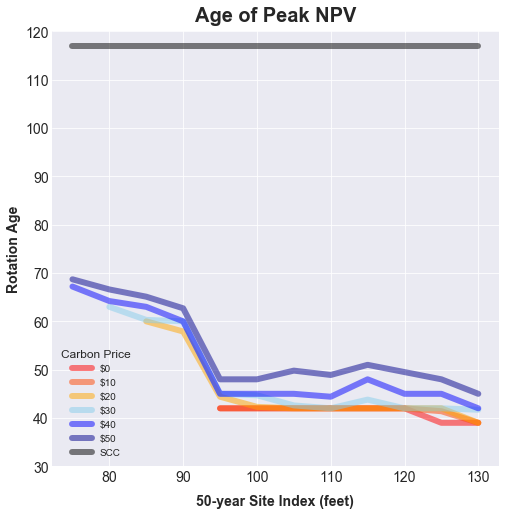

In [19]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
prices = ['00', '10', '20', '30', '40', '50', 'SC']
labels = ['${:.0f}'.format(int(i)) for i in prices[:-1]] + ['SCC']
colors = ['red', 'orangered', 'orange', 'skyblue', 'blue', 'darkblue', 'black']

positives = npv_summary.loc[npv_summary.pnv_smooth > 0]
npv_age_pivot = pd.pivot_table(positives, values='age', index='siteindex', columns='mgmtid', aggfunc='mean')

for i in range(len(prices)):
    ax.plot(npv_age_pivot['C_'+prices[i]], color=colors[i], lw=6, alpha=0.5, label=labels[i])
plt.legend(title='Carbon Price')
plt.title('Age of Peak NPV', fontsize=20, weight='bold', pad=10)
plt.xlabel("50-year Site Index (feet)", fontsize=14, weight='bold', labelpad=10)
plt.ylabel("Rotation Age", fontsize=14, weight='bold')
plt.legend().set_title('Carbon Price',prop={'size':12})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylim(30,120)
plt.savefig('PeakNPV_withCarbon.png');

In [21]:
npv_bdft_pivot = pd.pivot_table(npv_summary, values='mai_mcuft', index='siteindex', columns='mgmtid', aggfunc='mean')
npv_bdft_pivot.style.format("{:,.0f}")

mgmtid,C_00,C_05,C_10,C_15,C_20,C_25,C_30,C_35,C_40,C_45,C_50,C_SC
siteindex,,,,,,,,,,,,
75,103,102,102,102,102,103,103,103,103,103,103,88
80,107,107,107,108,108,108,108,108,108,108,108,92
85,113,113,113,113,113,113,113,113,113,112,111,95
90,117,117,117,117,117,116,116,116,116,115,114,97
95,168,168,167,167,166,165,165,165,165,167,169,134
100,172,172,172,172,172,173,177,179,178,178,179,140
105,186,185,185,186,186,186,186,186,186,186,182,145
110,193,192,193,193,193,192,192,192,190,189,189,151
115,231,232,230,230,231,231,231,231,232,232,231,164


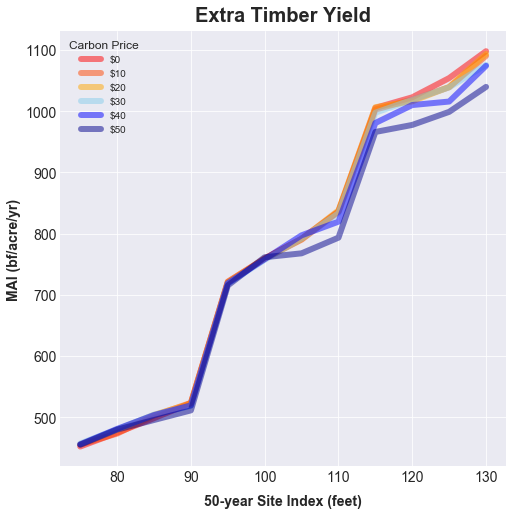

In [38]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
prices = ['00', '10', '20', '30', '40', '50']
labels = ['${:.0f}'.format(int(i)) for i in prices]
colors = ['red', 'orangered', 'orange', 'skyblue', 'blue', 'darkblue', 'black']

for i in range(len(prices)):
    ax.plot(npv_bdft_pivot['C_'+prices[i]], color=colors[i], lw=6, alpha=0.5, label=labels[i])

plt.title('Extra Timber Yield', fontsize=20, weight='bold', pad=10)
plt.xlabel("50-year Site Index (feet)", fontsize=14, weight='bold', labelpad=10)
plt.ylabel('MAI (bf/acre/yr)', fontsize=14, weight='bold')
plt.legend().set_title('Carbon Price',prop={'size':12})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('NPVYields_withCarbon.png');

In [39]:
npv_carbon_pivot = pd.pivot_table(npv_summary, values='carbon', index='siteindex', columns='mgmtid', aggfunc='mean')*44/12
npv_carbon_pivot.style.format("{:,.0f}")

mgmtid,C_00,C_05,C_10,C_15,C_20,C_25,C_30,C_35,C_40,C_45,C_50,C_SC
siteindex,,,,,,,,,,,,
75,278,279,279,280,283,291,292,292,297,300,302,458
80,279,278,281,286,293,294,293,297,299,305,308,475
85,282,291,291,292,292,293,294,302,306,308,313,488
90,290,290,290,290,294,302,302,302,303,307,314,499
95,342,342,342,356,364,369,370,370,370,379,394,720
100,357,356,356,359,359,364,382,386,385,398,410,749
105,371,370,370,370,371,371,376,398,398,399,439,772
110,384,383,384,384,385,384,384,388,405,410,445,794
115,420,420,418,419,420,419,441,455,488,489,518,894


In [40]:
npv_npv_pivot = pd.pivot_table(npv_summary, values='pnv_smooth', index='siteindex', columns='mgmtid', aggfunc='mean')
npv_npv_pivot.style.format("{:,.0f}")

mgmtid,C_00,C_05,C_10,C_15,C_20,C_25,C_30,C_35,C_40,C_45,C_50,C_SC
siteindex,,,,,,,,,,,,
75,-526,-453,-380,-304,-231,-162,-80,-1,81,172,251,"19,995"
80,-423,-349,-269,-182,-93,-5,81,169,272,353,453,"21,179"
85,-327,-259,-179,-94,6,99,188,280,375,463,554,"22,015"
90,-236,-158,-75,12,91,176,261,357,457,542,645,"22,735"
95,964,"1,060","1,160","1,262","1,382","1,490","1,609","1,716","1,869","1,982","2,100","34,905"
100,"1,078","1,202","1,318","1,434","1,549","1,674","1,805","1,942","2,079","2,213","2,364","36,562"
105,"1,208","1,325","1,443","1,562","1,692","1,814","1,941","2,075","2,217","2,364","2,509","37,777"
110,"1,310","1,436","1,564","1,693","1,822","1,952","2,079","2,206","2,353","2,501","2,653","38,991"
115,"1,717","1,838","1,935","2,056","2,191","2,304","2,416","2,576","2,723","2,888","3,060","44,702"


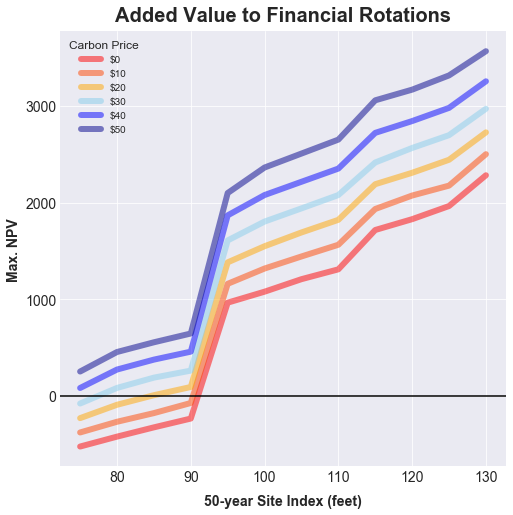

In [41]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
prices = ['00', '10', '20', '30', '40', '50']
colors = ['red', 'orangered', 'orange', 'skyblue', 'blue', 'darkblue', 'black']

for i in range(len(prices)):
    ax.plot(npv_npv_pivot['C_'+prices[i]], color=colors[i], label='${:.0f}'.format(int(prices[i])), lw=6, alpha=0.5)
plt.legend(title='Carbon Price')
plt.title('Added Value to Financial Rotations', fontsize=20, weight='bold', pad=10)
plt.xlabel("50-year Site Index (feet)", fontsize=14, weight='bold', labelpad=10)
plt.ylabel("Max. NPV", fontsize=14, weight='bold')
plt.legend().set_title('Carbon Price',prop={'size':12})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.axhline(y=0, c='k')
plt.savefig('NPV_moreNPV_withCarbon.png');

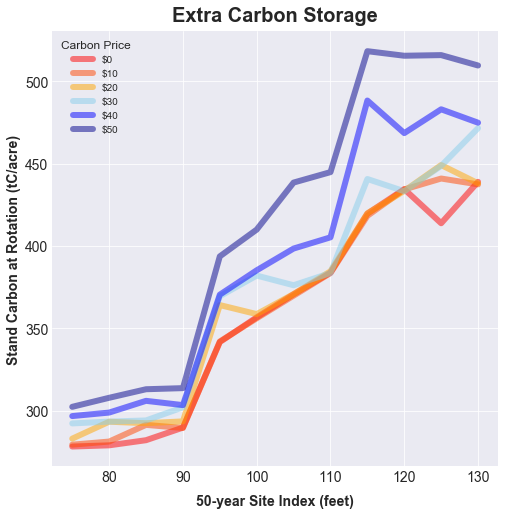

In [42]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
prices = ['00', '10', '20', '30', '40', '50']
colors = ['red', 'orangered', 'orange', 'skyblue', 'blue', 'darkblue', 'black']

for i in range(len(prices)):
    ax.plot(npv_carbon_pivot['C_'+prices[i]], color=colors[i], label='${:.0f}'.format(int(prices[i])), lw=6, alpha=0.5)

plt.title('Extra Carbon Storage', fontsize=20, weight='bold', pad=10)
plt.xlabel("50-year Site Index (feet)", fontsize=14, weight='bold', labelpad=10)
plt.ylabel('Stand Carbon at Rotation (tC/acre)', fontsize=14, weight='bold')
plt.legend().set_title('Carbon Price',prop={'size':12})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('NPVStandC_withCarbon.png');

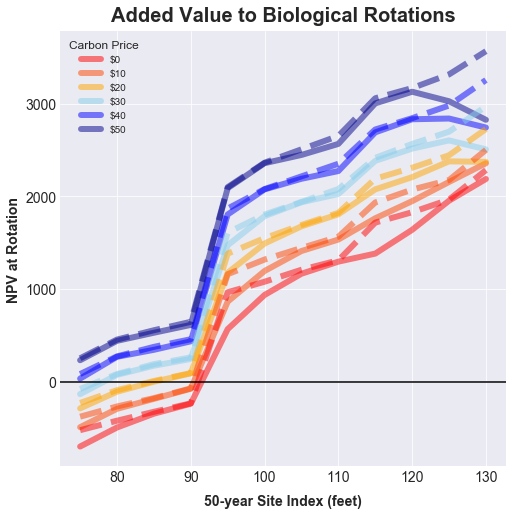

In [43]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
prices = ['00', '10', '20', '30', '40', '50']
colors = ['red', 'orangered', 'orange', 'skyblue', 'blue', 'darkblue', 'black']

for i in range(len(prices)):
    ax.plot(cmai_pnv_pivot['C_'+prices[i]], color=colors[i], label='${:.0f}'.format(int(prices[i])), lw=6, alpha=0.5)
    
for i in range(len(prices)):
    ax.plot(npv_npv_pivot['C_'+prices[i]], color=colors[i], lw=6, alpha=0.5, ls='--', label='')

plt.legend(title='Carbon Price')
plt.title('Added Value to Biological Rotations', fontsize=20, weight='bold', pad=10)
plt.xlabel("50-year Site Index (feet)", fontsize=14, weight='bold', labelpad=10)
plt.ylabel("NPV at Rotation", fontsize=14, weight='bold')
plt.legend().set_title('Carbon Price',prop={'size':12})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.axhline(y=0, c='k')
plt.savefig('moreNPV_withCarbon.png');